# Goal of this notebook

The goal of this notebook is to compare the extraction of all measurements in front of a SQL dataset considered as gold.
To do so, the algorithm has to extract the measurements (NER + measurement pipe) and link each found measurement to a row of the SQL dataset (Normalisation pipe)

# Formalisation du problème

1. Constituer un jeu de 20 documents CRH pour lesquels on a des données de biologie (encounter_num = clé de jointure pour une même visite --> lien table lab et table document), vérifier que la date de début visite/document/bio est la même à un ou deux jour près

2. NER sur ces documents + pipe valeur numérique 

3. "Normalisation" lien des mentions "BIO" extraites vers les termes des `c_name` associé au code laboratoire `concept_cd` dans i2b2_observation_lab (par fuzzy matching ou autre) comparaison des valeurs numériques et unité

In [1]:
%reload_ext autoreload
%autoreload 2
%config Completer.use_jedi = False
%reload_ext lab_black

In [2]:
import pandas as pd
import spacy
from edsnlp.processing import pipe
from os.path import isfile, isdir, join, basename
from os import listdir
from pyspark.sql.functions import datediff, abs
import torch
import matplotlib.pyplot as plt
from statistics import mean
import numpy as np
from joblib import Parallel, delayed

# Import unit registry for found-gold comparison
from edsnlp.pipelines.misc.measurements.patterns import units_config
from edsnlp.pipelines.misc.measurements.measurements import (
    SimpleMeasurement,
    UnitRegistry,
)

UNIT_REGISTRY = UnitRegistry(units_config)

# Import measurements extractor
import sys

sys.path.insert(1, "/export/home/cse200093/Jacques_Bio/super_pipe/py_files/")
import extract_measurements_from_brat


SQL_PATH = (
    "/export/home/cse200093/Jacques_Bio/data_bio/super_pipe_evaluate_on_sql_dataset/"
)
DATA_PATH = "/export/home/cse200093/Jacques_Bio/data_bio/super_pipe_res/i2b2_comparison/res.json"
SAVE_PATH = "/export/home/cse200093/Jacques_Bio/data_bio/super_pipe_res/i2b2_comparison/gold_all_measurements.json"
DATA_EMB_DIR = "/export/home/cse200093/Jacques_Bio/data_bio/super_pipe_res/i2b2_comparison/super_pipe_embeddings_from_sql_dataset.pt"
GOLD_EMB_DIR = "/export/home/cse200093/Jacques_Bio/data_bio/super_pipe_res/i2b2_comparison/super_pipe_gold_all_measurements_embeddings_from_sql_dataset.pt"

In [3]:
# Show tables we can use
sql("USE cse_200093_20210402")
sql("SHOW tables").show(10, False)

+-------------------+-------------------------+-----------+
|database           |tableName                |isTemporary|
+-------------------+-------------------------+-----------+
|cse_200093_20210402|i2b2_concept             |false      |
|cse_200093_20210402|i2b2_observation_ccam    |false      |
|cse_200093_20210402|i2b2_observation_cim10   |false      |
|cse_200093_20210402|i2b2_observation_doc     |false      |
|cse_200093_20210402|i2b2_observation_ghm     |false      |
|cse_200093_20210402|i2b2_observation_lab     |false      |
|cse_200093_20210402|i2b2_observation_med     |false      |
|cse_200093_20210402|i2b2_observation_microbio|false      |
|cse_200093_20210402|i2b2_observation_pacs    |false      |
|cse_200093_20210402|i2b2_observation_physio  |false      |
+-------------------+-------------------------+-----------+
only showing top 10 rows



The tables that take our interest are:
- i2b2_observation_lab for the measurements
- i2b2_observation_doc for raw doc
- i2b2_ontology for bio name

Links between tables are:
- i2b2_observation_lab["encounter_num"] and i2b2_observation_doc["encounter_num"]
- i2b2_observation_lab["concept_cd"] and i2b2_ontology["c_basecode"]

In [8]:
# SKIP THIS PART IF TRAINING DATASET ALREADY BUILT
# Create our training dataset
N_DOCS = 500
observation_df = sql("SELECT encounter_num, observation_blob FROM i2b2_observation_doc WHERE concept_cd == 'CR:CRH-HOSPI' ORDER BY RAND() LIMIT " + str(N_DOCS)).toPandas()
# Create edsnlp pipe to select N_DOCS which contains a table
nlp_tables = spacy.blank("eds")
nlp_tables.add_pipe("eds.tables")
observation_df = observation_df.rename(columns={"encounter_num":"note_id", "observation_blob":"note_text"}).dropna()
observation_with_tables_df = pipe(
    note=observation_df,
    nlp = nlp_tables,
    n_jobs=-2,
    additional_spans = ["tables"],
)
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(observation_with_tables_df)

[Parallel(n_jobs=-2)]: Using backend MultiprocessingBackend with 4 concurrent workers.
[Parallel(n_jobs=-2)]: Done   2 out of   5 | elapsed:    1.4s remaining:    2.0s
[Parallel(n_jobs=-2)]: Done   3 out of   5 | elapsed:    1.4s remaining:    0.9s
[Parallel(n_jobs=-2)]: Done   5 out of   5 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=-2)]: Done   5 out of   5 | elapsed:    2.4s finished


,note_id,lexical_variant,label,span_type,start,end
0,5559442752890944282,Pat.: A. BEN LASSIN | F | 18/05/1963 | 8011344...,table,tables,654,717
1,5559442752890944282,Pat.: A. BEN LASSIN | F | 18/05/1963 | 8011344...,table,tables,3126,3189
2,-5631782257767354020,|12/06/14 |05/06/14 |05/06/14 |\nAnalyse |Unit...,table,tables,2674,2756
3,-5631782257767354020,Leucocytes |x10*9/L | |9.7 | |4.0-10.0\nHémogl...,table,tables,2876,2994
4,-5631782257767354020,INR | |3.31 |1.08 | |\n,table,tables,3018,3040
5,-5631782257767354020,Sodium |mmol/L | | |141 |136-145\nPotassium |m...,table,tables,3067,3273
6,-5631782257767354020,NT Pro-BNP |ng/L | | |641 |\n,table,tables,3294,3322
7,2971694757939888041,"sur le plan m¨¦tabolique: \n Depuis 1980, lup...",table,tables,1212,1387
8,2971694757939888041, Novembre 2013: phl¨¦bite du membre inf¨¦rieu...,table,tables,1395,1606
9,2971694757939888041, En 2012: grippe grave ¨¤ H1N1 ayant n¨¦cessi...,table,tables,1774,1840


In [15]:
# SKIP THIS PART IF TRAINING DATASET ALREADY BUILT
# Thx to the preceding studeis, we select 20 encounter_nums for our dataset
training_encounter_num_list = [
    "3311717742106114198",
    "-9207365714292542456",
    "-8737094211247099154",
    "8297547063719674995",
    "4321502451070890961",
    "4712334113846799007",
    "6274264545954165202",
    "2902895187828816488",
    "70342063698275685",
    "1616410736525590834",
    "-2404320285860453818",
    "-8701297496299978451",
    "-7581086757542474166",
    "-3275552249497635487",
    "6607565759426375557",
    "-4948466346133130728",
    "-7023136077240002139",
    "-951623942209120883",
    "8594067165464392657",
    "-2420225213879593913"
]
# Loading this dataset
training_df = sql("SELECT encounter_num, observation_blob FROM i2b2_observation_doc WHERE concept_cd == 'CR:CRH-HOSPI'")
training_df = training_df.filter(training_df.encounter_num.isin(training_encounter_num_list)).toPandas()
display(training_df)

# Save txt
def save_to_txt(name, txt):
    with open(SQL_PATH + name + ".txt", "w") as f:
        print(txt, file=f)

training_df.apply(lambda row: save_to_txt(row["encounter_num"], row["observation_blob"]), axis=1)

,encounter_num,observation_blob
0,70342063698275685,20/01/2020 01:1919/01/2020 20:15\nAITOULKA\nAG...
1,3311717742106114198,Objet : BCH CRH NEPHRO du 25/04 au 03/05/2019\...
2,-7023136077240002139,01/04/2020 19:3501/04/2020 14:05\nABOYOUSSEF\n...
3,-9207365714292542456,17/10/2019 19:0217/10/2019 15:01\n18/10/2019 1...
4,4712334113846799007,Compte-rendu d'évolution UHCD\nEntrée aux urge...
5,6607565759426375557,Compte-rendu d'évolution UHCD\nEntrée aux urge...
6,-8737094211247099154,28/12/2019 20:1328/12/2019 10:59\nADJANOUGA AL...
7,4321502451070890961,1/8 Mme Efrossini LE GUEZIEC 8010882151 \n \n ...
8,8297547063719674995,COMPTE-RENDU D'HOSPITALISATION\neffner\nMadame...
9,70342063698275685,20/01/2020 01:1919/01/2020 20:15\nAITOULKA\nA....


0     None
1     None
2     None
3     None
4     None
5     None
6     None
7     None
8     None
9     None
10    None
11    None
12    None
13    None
14    None
15    None
16    None
17    None
18    None
19    None
20    None
dtype: object

In [4]:
# SKIP THIS PART IF TRAINING DATASET ALREADY BUILT

# Select all bio measurements from the documents in our dataset
# N_MAX_DIFF_DAYS = 2
# Max number of days of difference between a measurement and the date of visit

training_encounter_num_list = [
    f[:-4] for f in listdir(SQL_PATH) if isfile(join(SQL_PATH, f)) if f.endswith(".txt")
]

# Creating dataset
i2b2_observation_lab = sql(
    "SELECT encounter_num, concept_cd, nval_num, units_cd, start_date FROM i2b2_observation_lab"
).withColumnRenamed("start_date", "start_date_lab")
i2b2_ontology = sql("SELECT c_basecode, c_name FROM i2b2_ontology")
measurements_dataset = sql(
    "SELECT encounter_num, start_date FROM i2b2_observation_doc WHERE concept_cd == 'CR:CRH-HOSPI'"
).withColumnRenamed("start_date", "start_date_doc")
measurements_dataset = measurements_dataset.filter(
    measurements_dataset.encounter_num.isin(training_encounter_num_list)
)
measurements_dataset = measurements_dataset.join(
    i2b2_observation_lab, "encounter_num", "inner"
)
# Filter the measurements to have a date not too far from the one registered with observation_lab
"""
measurements_dataset = measurements_dataset.filter(
    abs(
        datediff(
            measurements_dataset.start_date_doc, measurements_dataset.start_date_lab
        )
    )
    < N_MAX_DIFF_DAYS
)
"""
measurements_dataset = measurements_dataset.join(
    i2b2_ontology, measurements_dataset.concept_cd == i2b2_ontology.c_basecode, "inner"
)
measurements_df = measurements_dataset.toPandas()
measurements_df = measurements_df.loc[~measurements_df["nval_num"].isnull()].drop(
    columns=["start_date_doc", "start_date_lab", "concept_cd", "c_basecode"]
)
measurements_df

,encounter_num,nval_num,units_cd,c_name
0,-951623942209120883,1.50,g/l,A0020 : Apolipoprotéine AI_Sérum/Plasma_Turbid...
1,4321502451070890961,1.91,g/L,A0020 : Apolipoprotéine AI_Sérum/Plasma_Turbid...
2,-951623942209120883,0.82,g/l,A0021 : Apolipoprotéine B_Sérum/Plasma_g/L (Un...
3,4321502451070890961,0.99,g/L,A0021 : Apolipoprotéine B_Sérum/Plasma_g/L (Un...
4,-3275552249497635487,3.00,µmol/L,A0028 : Bilirubine conjuguée_Sérum/Plasma_µmol...
...,...,...,...,...
6873,70342063698275685,0.20,.,H6256 : Scl 70 anticorps Titre_Sérum_Cytométri...
6874,70342063698275685,18.20,UGPL,H6272 : Cardiolipine anticorps IgG Titre_Sérum...
6875,70342063698275685,18.20,UGPL,H6272 : Cardiolipine anticorps IgG Titre_Sérum...
6876,6607565759426375557,1.60,UGPL,H6272 : Cardiolipine anticorps IgG Titre_Sérum...


In [5]:
# SKIP THIS PART IF TRAINING DATASET ALREADY BUILT

# Extract terms of c_name column


def get_term_from_c_name(c_name):
    return c_name[c_name.index(":") + 1 :].split("_")[0].strip()


measurements_df["term"] = measurements_df["c_name"].apply(get_term_from_c_name)
measurements_df = measurements_df.copy().drop_duplicates()
measurements_df

,encounter_num,nval_num,units_cd,c_name,term
0,-951623942209120883,1.50,g/l,A0020 : Apolipoprotéine AI_Sérum/Plasma_Turbid...,Apolipoprotéine AI
1,4321502451070890961,1.91,g/L,A0020 : Apolipoprotéine AI_Sérum/Plasma_Turbid...,Apolipoprotéine AI
2,-951623942209120883,0.82,g/l,A0021 : Apolipoprotéine B_Sérum/Plasma_g/L (Un...,Apolipoprotéine B
3,4321502451070890961,0.99,g/L,A0021 : Apolipoprotéine B_Sérum/Plasma_g/L (Un...,Apolipoprotéine B
4,-3275552249497635487,3.00,µmol/L,A0028 : Bilirubine conjuguée_Sérum/Plasma_µmol...,Bilirubine conjuguée
...,...,...,...,...,...
6868,70342063698275685,2.81,g/L,G7663 : Haptoglobine_Sérum/Plasma_Turbidimétri...,Haptoglobine
6872,70342063698275685,0.20,.,H6256 : Scl 70 anticorps Titre_Sérum_Cytométri...,Scl 70 anticorps Titre
6874,70342063698275685,18.20,UGPL,H6272 : Cardiolipine anticorps IgG Titre_Sérum...,Cardiolipine anticorps IgG Titre
6876,6607565759426375557,1.60,UGPL,H6272 : Cardiolipine anticorps IgG Titre_Sérum...,Cardiolipine anticorps IgG Titre


In [6]:
# SKIP THIS PART IF TRAINING DATASET ALREADY BUILT

# Fill None units with `nounit` and remove empty measures

measurements_df.loc[measurements_df["units_cd"].isna(), "units_cd"] = "nounit"
measurements_df = measurements_df.loc[measurements_df["nval_num"].notna()]
measurements_df["encounter_num"] = measurements_df["encounter_num"].apply(
    lambda encounter_num: str(encounter_num) + ".ann"
)
measurements_df

,encounter_num,nval_num,units_cd,c_name,term
0,-951623942209120883.ann,1.50,g/l,A0020 : Apolipoprotéine AI_Sérum/Plasma_Turbid...,Apolipoprotéine AI
1,4321502451070890961.ann,1.91,g/L,A0020 : Apolipoprotéine AI_Sérum/Plasma_Turbid...,Apolipoprotéine AI
2,-951623942209120883.ann,0.82,g/l,A0021 : Apolipoprotéine B_Sérum/Plasma_g/L (Un...,Apolipoprotéine B
3,4321502451070890961.ann,0.99,g/L,A0021 : Apolipoprotéine B_Sérum/Plasma_g/L (Un...,Apolipoprotéine B
4,-3275552249497635487.ann,3.00,µmol/L,A0028 : Bilirubine conjuguée_Sérum/Plasma_µmol...,Bilirubine conjuguée
...,...,...,...,...,...
6868,70342063698275685.ann,2.81,g/L,G7663 : Haptoglobine_Sérum/Plasma_Turbidimétri...,Haptoglobine
6872,70342063698275685.ann,0.20,.,H6256 : Scl 70 anticorps Titre_Sérum_Cytométri...,Scl 70 anticorps Titre
6874,70342063698275685.ann,18.20,UGPL,H6272 : Cardiolipine anticorps IgG Titre_Sérum...,Cardiolipine anticorps IgG Titre
6876,6607565759426375557.ann,1.60,UGPL,H6272 : Cardiolipine anticorps IgG Titre_Sérum...,Cardiolipine anticorps IgG Titre


In [8]:
# No boolean stored in i2b2

with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(measurements_df.loc[measurements_df["units_cd"] == "nounit"])

display(measurements_df["units_cd"].unique())

,encounter_num,nval_num,units_cd,c_name,term
57,70342063698275685.ann,1.07,nounit,A0352 : Temps de venin vipère Russell dilué Pa...,Temps de venin vipère Russell dilué Patient/té...
147,3311717742106114198.ann,0.21,nounit,F2073 : Hépatite B virus antigène HBs Index_Sé...,Hépatite B virus antigène HBs Index
178,6274264545954165202.ann,1.01,nounit,A0004 : Albumine /globulines_Sérum_Electrophor...,Albumine /globulines
366,4321502451070890961.ann,0.05,nounit,D2624 : Hépatite B virus anticorps HBc Index_S...,Hépatite B virus anticorps HBc Index
367,3311717742106114198.ann,0.07,nounit,D2624 : Hépatite B virus anticorps HBc Index_S...,Hépatite B virus anticorps HBc Index
368,4321502451070890961.ann,0.06,nounit,D2769 : Hépatite C virus anticorps Index_Sérum...,Hépatite C virus anticorps Index
369,3311717742106114198.ann,0.09,nounit,D2769 : Hépatite C virus anticorps Index_Sérum...,Hépatite C virus anticorps Index
612,6607565759426375557.ann,1.18,nounit,C5548 : Temps de Quick INR (Protocole)_PPP_Coa...,Temps de Quick INR (Protocole)
613,-3275552249497635487.ann,1.25,nounit,C5548 : Temps de Quick INR (Protocole)_PPP_Coa...,Temps de Quick INR (Protocole)
630,4321502451070890961.ann,10.12,nounit,D2608 : Hépatite A virus anticorps IgG Index_S...,Hépatite A virus anticorps IgG Index


array(['g/L', 'µmol/L', 'µmol/l', 'mmol/L', '%', 'mmol/l', 'nounit',
       'x10*9/L', 's', 'pmol/L', 'mg/mmol', 'g/dl', 'g/dL', 'nmol/L',
       'µg/L', 'mg/dL', 'UA/mL', 'UA/ml', 'mL/min/1,73m²', 'U/L', 'U/mL',
       'U/l', 'fL', 'UI/mL', 'mm Hg', 'mmHg', 'mm hg', 'mL/dL', 'ng/mL',
       'UI/L', 'pg', 'mg/L', 'mg/l', 'x10*12/L', 'mL/min/1.73m²',
       'g/mmol', 'pg/mL', '°C', 'ng/L', 'mU/L', 'UMPL', 'fl', 'Giga/l',
       'Téra/l', 'mOsmol/L', 'log UI/ml', 'L/min', 'mm', 'UGPL'],
      dtype=object)

In [7]:
# SKIP THIS PART IF TRAINING DATASET ALREADY BUILT

# Create the gold column which consists in the entire measure + join the same terms of each doc together

measurements_df["gold"] = measurements_df[["nval_num", "units_cd"]].apply(
    lambda row: str(row["nval_num"]) + " " + row["units_cd"], axis=1
)
measurements_df = (
    measurements_df.groupby(["encounter_num", "term"])
    .agg({"encounter_num": "first", "term": "first", "c_name": list, "gold": list})
    .reset_index(drop=True)
)
measurements_df

,encounter_num,term,c_name,gold
0,-2404320285860453818.ann,Alanine aminotransférase Avec Phosphate de pyr...,[E2067 : Alanine aminotransférase Avec Phospha...,"[73.0 U/l, 92.0 U/l, 150.0 U/l, 97.0 U/l, 89.0..."
1,-2404320285860453818.ann,Albumine,[C7088 : Albumine_Sérum_Electrophorèse 2_g/L (...,"[32.7 g/L, 36.6 g/L, 31.6 g/L, 34.7 g/L, 38.0 ..."
2,-2404320285860453818.ann,Albumine /protéines totales,[C7087 : Albumine /protéines totales_Sérum_Ele...,"[65.0 %, 67.7 %, 63.2 %]"
3,-2404320285860453818.ann,Alpha-1-globulines,[C7090 : Alpha-1-globulines_Sérum_Electrophorè...,"[3.3 g/L, 2.6 g/L, 3.7 g/L, 3.2 g/L]"
4,-2404320285860453818.ann,Alpha-1-globulines /protéines totales,[C7089 : Alpha-1-globulines /protéines totales...,"[6.5 %, 4.8 %, 7.3 %, 5.9 %]"
...,...,...,...,...
1380,8594067165464392657.ann,Température corporelle,[A7332 : Température corporelle_Patient_°C (Un...,[36.8 °C]
1381,8594067165464392657.ann,Troponine Ic Hypersensible,[G7716 : Troponine Ic Hypersensible_Sérum/Plas...,"[35.0 ng/L, 20.0 ng/L]"
1382,8594067165464392657.ann,Urée,[A0286 : Urée_Sérum/Plasma_mmol/L (Unités : mm...,"[6.4 mmol/L, 9.5 mmol/L]"
1383,8594067165464392657.ann,pH,[A0221 : pH_Sang artériel (Unités : inconnues ...,"[7.36 nounit, 7.37 nounit]"


In [11]:
# SKIP THIS PART IF TRAINING DATASET ALREADY BUILT

# Save gold df
measurements_df.to_json(SAVE_PATH)

# Now please do inference of CODER on GPU using the files in `"/export/home/cse200093/Jacques_Bio/super_pipe/py_files`
## You just need to modify `config.py` to your needs (with at least `do_ner = do_measurements_pipe = False` and `do_coder=True` and `column_name_to_normalize = "term"` and with a data embeddings save path)

In [38]:
# Load data and embeddings to find best match
data_df = pd.read_json(DATA_PATH)
gold_df = pd.read_json(SAVE_PATH)
data_emb = torch.load(DATA_EMB_DIR, map_location=torch.device("cpu"))
gold_emb = torch.load(GOLD_EMB_DIR, map_location=torch.device("cpu"))

# In some cases, some doocuments were not annotated. We decide to drop them.
data_df = data_df.loc[data_df["source"].isin(gold_df["encounter_num"].unique())]

In [39]:
# Group all measures linked to a same bio term
# And remove all booleans
data_df_cleant = data_df.copy().drop(columns=["span_converted"])
data_df_cleant["id"] = data_df.index

# Function to check if there are only booleans measurements
def not_only_boolean_checker(measurements):
    for measurement in measurements:
        if "bool" not in measurement:
            return True
    return False


data_df_cleant = data_df_cleant.loc[
    data_df_cleant["found"].apply(not_only_boolean_checker)
].reset_index(drop=True)
data_df_cleant["found"] = data_df_cleant["found"].apply(tuple)
data_df_cleant["label"] = data_df_cleant["label"].apply(tuple)
data_df_cleant = (
    data_df_cleant.groupby(["source", "terms_linked_to_measurement"])
    .agg(
        {
            "id": "first",
            "term": list,
            "source": "first",
            "terms_linked_to_measurement": "first",
            "found": sum,
            "label": sum,
            "des": list,
        }
    )
    .reset_index(drop=True)
)

In [40]:
# Do cosim and get prediction


def get_sim_results(
    data_emb,
    gold_emb,
    gold_idx,
):
    sim = torch.matmul(data_emb, gold_emb.t())
    most_similar = torch.max(sim, dim=1)[1].tolist()
    res_idx = [gold_idx[idx] for idx in most_similar]
    return res_idx


data_df_parts = []
for ann_file in data_df_cleant["source"].unique():
    data_df_part = data_df_cleant.copy().loc[data_df_cleant["source"] == ann_file]
    data_idx = data_df_part["id"].tolist()
    gold_idx = gold_df.copy().loc[gold_df["encounter_num"] == ann_file].index
    res_idx = get_sim_results(data_emb[data_idx], gold_emb[gold_idx], gold_idx)
    data_df_part["gold"] = gold_df.iloc[res_idx]["gold"].tolist()
    data_df_part["gold_term"] = gold_df.iloc[res_idx]["term"].tolist()
    data_df_part["gold_label"] = gold_df.iloc[res_idx]["label"].tolist()
    data_df_part["gold_des"] = gold_df.iloc[res_idx]["des"].tolist()
    data_df_parts.append(data_df_part)

res_df = pd.concat(data_df_parts, ignore_index=True)
res_df

,id,term,source,terms_linked_to_measurement,found,label,des,gold,gold_term,gold_label,gold_des
0,532,[ALAT ¦U/l ¦ ¦ ¦73 + ¦<35],-2404320285860453818.ann,ALAT,"(73.0 ui_per_l,)","(C0201836,)",[ALT],"[70.0 U/l, 38.0 U/l, 54.0 U/l, 48.0 U/l, 43.0 ...",Gamma glutamyltransférase,[C0202035],Gamma glutamyltransferase
1,531,[ASAT ¦U/l ¦ ¦ ¦34…⁹ ¦<35],-2404320285860453818.ann,ASAT,"(34.0 ui_per_l,)","(C0201899,)",[ASAT],"[34.0 U/l, 42.0 U/l, 94.0 U/l, 26.0 U/l, 11.0 ...",Aspartate aminotransférase Avec Phosphate de p...,[C0523461],Alanine aminotransferase pyridoxal 5 phosphate
2,529,[Acide urique ¦µmol/l ¦ ¦ ¦291 ¦140-340],-2404320285860453818.ann,Acide urique,"(291.0 µmol_per_l,)","(C0202239,)",[Acide urique],"[291.0 µmol/l, 299.0 µmol/l, 319.0 µmol/l, 255...",Urate,[C0202239],URATE
3,526,[Albumine plasmatique¦g/L ¦ ¦ ¦38 ¦35-52],-2404320285860453818.ann,Albumine plasmatique,"(38.0 g_per_l,)","(C1272106,)",[Plasma albumin],"[65.0 %, 67.7 %, 63.2 %]",Albumine /protéines totales,[C1293929],ratio analyte albumin
4,519,[Bicarbonate ¦mmol/l ¦ ¦ ¦24.2 ¦22.0-29.0],-2404320285860453818.ann,Bicarbonate,"(24.2 mmol_per_l,)","(C0202059,)",[Bicarbonate],"[24.2 mmol/l, 23.1 mmol/l, 22.7 mmol/l, 23.6 m...",Bicarbonate,[C0202059],Bicarbonate
...,...,...,...,...,...,...,...,...,...,...,...
828,8,[pCO2/T° patient ¦mm Hg ¦50 + ¦35-45],8594067165464392657.ann,pCO2/T° patient,"(50.0 mm_hg,)","(C0428189,)",[blood PaCO2 lab],[50.0 mm Hg],Carbone dioxyde pression(mmHg) Corrigé(e) par ...,[C0430212],PCO2 Ur plas par pres CO2 grad
829,4,[pH ¦ ¦7.36 ¦7.35-7.45],8594067165464392657.ann,pH,"(7.36 nounit,)","(C0202165,)",[pH],"[7.36 nounit, 7.37 nounit]",pH,[C0202165],pH
830,7,[pH/T° patient ¦ ¦7.36 ¦7.35-7.45],8594067165464392657.ann,pH/T° patient,"(7.36 nounit,)","(C1266221,)",[pH combined acid],[7.36 nounit],pH Ajusté(e) à la température du patient,[C1446175],pleural pH lab
831,6,[pO2 ¦mm Hg ¦78 - ¦>80],8594067165464392657.ann,pO2,"(78.0 mm_hg,)","(C1283004,)",[PO2],"[93.7 %, 97.1 %]",Oxygène saturation,[C0523807],Oxygen Saturation


In [41]:
# Study of results

with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(res_df)

,id,term,source,terms_linked_to_measurement,found,label,des,gold,gold_term,gold_label,gold_des
0,532,[ALAT ¦U/l ¦ ¦ ¦73 + ¦<35],-2404320285860453818.ann,ALAT,"(73.0 ui_per_l,)","(C0201836,)",[ALT],"[70.0 U/l, 38.0 U/l, 54.0 U/l, 48.0 U/l, 43.0 ...",Gamma glutamyltransférase,[C0202035],Gamma glutamyltransferase
1,531,[ASAT ¦U/l ¦ ¦ ¦34…⁹ ¦<35],-2404320285860453818.ann,ASAT,"(34.0 ui_per_l,)","(C0201899,)",[ASAT],"[34.0 U/l, 42.0 U/l, 94.0 U/l, 26.0 U/l, 11.0 ...",Aspartate aminotransférase Avec Phosphate de p...,[C0523461],Alanine aminotransferase pyridoxal 5 phosphate
2,529,[Acide urique ¦µmol/l ¦ ¦ ¦291 ¦140-340],-2404320285860453818.ann,Acide urique,"(291.0 µmol_per_l,)","(C0202239,)",[Acide urique],"[291.0 µmol/l, 299.0 µmol/l, 319.0 µmol/l, 255...",Urate,[C0202239],URATE
3,526,[Albumine plasmatique¦g/L ¦ ¦ ¦38 ¦35-52],-2404320285860453818.ann,Albumine plasmatique,"(38.0 g_per_l,)","(C1272106,)",[Plasma albumin],"[65.0 %, 67.7 %, 63.2 %]",Albumine /protéines totales,[C1293929],ratio analyte albumin
4,519,[Bicarbonate ¦mmol/l ¦ ¦ ¦24.2 ¦22.0-29.0],-2404320285860453818.ann,Bicarbonate,"(24.2 mmol_per_l,)","(C0202059,)",[Bicarbonate],"[24.2 mmol/l, 23.1 mmol/l, 22.7 mmol/l, 23.6 m...",Bicarbonate,[C0202059],Bicarbonate
5,536,[Bilirubine conjuguée¦µmol/l ¦ ¦ ¦3.0…¹¹ ¦<3.4],-2404320285860453818.ann,Bilirubine conjuguée,"(3.0 µmol_per_l,)","(C0201916,)",[Bilirubin conjugated],"[3.0 µmol/l, 6.0 µmol/l, 4.0 µmol/l, 7.0 µmol/...",Bilirubine conjuguée,[C0201916],Bilirubin conjugated
6,535,[Bilirubine totale ¦µmol/l ¦ ¦ ¦10.0 ¦<21.0],-2404320285860453818.ann,Bilirubine totale,"(10.0 µmol_per_l,)","(C0201913,)",[Bilirubine totale],"[10.0 µmol/l, 15.0 µmol/l, 11.0 µmol/l, 17.0 µ...",Bilirubine totale,[C0201913],Bilirubine totale
7,510,"[CCMH ¦g/dl ¦ ¦34 ¦ ¦32-36, CCMH ¦g/dl ¦35 ¦32...",-2404320285860453818.ann,CCMH,"(34.0 g_per_dl, 35.0 g_per_dl)","(C0474535, C0474535)","[CCMH, CCMH]","[100.0 %, 91.0 %, 85.0 %, 69.0 %, 78.0 %, 72.0 %]",Temps de Quick,[C0033707],Quick one stage prothrombin time
8,530,[CRP ¦mg/l ¦ ¦ ¦1.0 ¦<5.0],-2404320285860453818.ann,CRP,"(1.0 mg_per_l,)","(C0201657,)",[CRP],"[1.0 mg/l, 5.8 mg/l]",Protéine C réactive,[C0201657],Proteine C reactive
9,525,[Calcium ¦mmol/l ¦ ¦ ¦2.31 ¦2.15-2.55],-2404320285860453818.ann,Calcium,"(2.31 mmol_per_l,)","(C0201925,)",[CALCIUM],"[2.31 mmol/l, 2.25 mmol/l, 2.36 mmol/l, 2.28 m...",Calcium,[C0201925],CALCIUM


In [42]:
# Convert to SimpleMeasurement to evaluate precision in further step
measurements_extractor = extract_measurements_from_brat.ExtractMeasurements()
nlp = measurements_extractor.nlp_from_label_key


def convert_to_SimpleMeasurement(measurement, gold, unit_registry=UNIT_REGISTRY):
    if gold:
        doc = nlp(measurement)
        return doc.spans["measurements"][0]._.value
    else:
        value_unit = measurement.split(" ")
        return SimpleMeasurement(
            value_range="=",
            value=float(value_unit[0]),
            unit=value_unit[1],
            registry=unit_registry,
        )


# Found are stored with a unit written as STH_PER_STH... so we can directly use SimpleMeasurement class
res_df["found"] = res_df["found"].apply(
    lambda measurements: [
        convert_to_SimpleMeasurement(measurement, False) for measurement in measurements
    ]
)
# Gold are stored with human written units so we need the measurements pipe to extract the measurements
res_df["gold"] = res_df["gold"].apply(
    lambda measurements: [
        convert_to_SimpleMeasurement(measurement, True) for measurement in measurements
    ]
)

display(res_df)

,id,term,source,terms_linked_to_measurement,found,label,des,gold,gold_term,gold_label,gold_des
0,532,[ALAT ¦U/l ¦ ¦ ¦73 + ¦<35],-2404320285860453818.ann,ALAT,[73.0 ui_per_l],"(C0201836,)",[ALT],"[70.0 ui_per_l, 38.0 ui_per_l, 54.0 ui_per_l, ...",Gamma glutamyltransférase,[C0202035],Gamma glutamyltransferase
1,531,[ASAT ¦U/l ¦ ¦ ¦34…⁹ ¦<35],-2404320285860453818.ann,ASAT,[34.0 ui_per_l],"(C0201899,)",[ASAT],"[34.0 ui_per_l, 42.0 ui_per_l, 94.0 ui_per_l, ...",Aspartate aminotransférase Avec Phosphate de p...,[C0523461],Alanine aminotransferase pyridoxal 5 phosphate
2,529,[Acide urique ¦µmol/l ¦ ¦ ¦291 ¦140-340],-2404320285860453818.ann,Acide urique,[291.0 µmol_per_l],"(C0202239,)",[Acide urique],"[291.0 µmol_per_l, 299.0 µmol_per_l, 319.0 µmo...",Urate,[C0202239],URATE
3,526,[Albumine plasmatique¦g/L ¦ ¦ ¦38 ¦35-52],-2404320285860453818.ann,Albumine plasmatique,[38.0 g_per_l],"(C1272106,)",[Plasma albumin],"[65.0 percent, 67.7 percent, 63.2 percent]",Albumine /protéines totales,[C1293929],ratio analyte albumin
4,519,[Bicarbonate ¦mmol/l ¦ ¦ ¦24.2 ¦22.0-29.0],-2404320285860453818.ann,Bicarbonate,[24.2 mmol_per_l],"(C0202059,)",[Bicarbonate],"[24.2 mmol_per_l, 23.1 mmol_per_l, 22.7 mmol_p...",Bicarbonate,[C0202059],Bicarbonate
...,...,...,...,...,...,...,...,...,...,...,...
828,8,[pCO2/T° patient ¦mm Hg ¦50 + ¦35-45],8594067165464392657.ann,pCO2/T° patient,[50.0 mm_hg],"(C0428189,)",[blood PaCO2 lab],[50.0 mm_hg],Carbone dioxyde pression(mmHg) Corrigé(e) par ...,[C0430212],PCO2 Ur plas par pres CO2 grad
829,4,[pH ¦ ¦7.36 ¦7.35-7.45],8594067165464392657.ann,pH,[7.36 nounit],"(C0202165,)",[pH],"[7.36 nounit, 7.37 nounit]",pH,[C0202165],pH
830,7,[pH/T° patient ¦ ¦7.36 ¦7.35-7.45],8594067165464392657.ann,pH/T° patient,[7.36 nounit],"(C1266221,)",[pH combined acid],[7.36 nounit],pH Ajusté(e) à la température du patient,[C1446175],pleural pH lab
831,6,[pO2 ¦mm Hg ¦78 - ¦>80],8594067165464392657.ann,pO2,[78.0 mm_hg],"(C1283004,)",[PO2],"[93.7 percent, 97.1 percent]",Oxygène saturation,[C0523807],Oxygen Saturation


In [43]:
# Calculate precision
def get_tpfp(found_measures, gold_measures):
    # TRUE AND FALSE POSITIVES
    for found in found_measures:
        for gold in gold_measures:
            try:
                if found == gold:
                    return [1, 0]
            except:
                continue
    return [0, 1]


tp, fp = [
    sum(x)
    for x in zip(
        *[
            get_tpfp(found_measures, gold_measures)
            for found_measures, gold_measures in zip(
                res_df["found"].to_list(), res_df["gold"].to_list()
            )
        ]
    )
]
print(tp, fp)
precision = round(tp / (tp + fp), 2)
print("True positives: " + str(tp))
print("False positives: " + str(fp))
print("Precision: " + str(precision))

618 215
True positives: 618
False positives: 215
Precision: 0.74


# Trying a link based on fuzzy matching instead of CODER
## We can still use the json given by our super_pipe, we will just not use the CUIs and the embeddings generated

In [29]:
# Load data and embeddings to find best match
data_df = pd.read_json(DATA_PATH)
gold_df = pd.read_json(SAVE_PATH)

# In some cases, some documents were not annotated. We decide to drop them.
data_df = data_df.loc[data_df["source"].isin(gold_df["encounter_num"].unique())]

# Drop columns linked to UMLS
data_df = data_df.drop(columns=["label", "des"])
gold_df = gold_df.drop(columns=["label", "des"])

In [30]:
# Fuzzy matcher definition
# Sorensen matcher definition
N_GRAM = 3


def tokenize(txt, n_gram=N_GRAM):
    padding = "#" * (n_gram - 1)
    return set(
        [
            (padding + txt + padding)[i : i + n_gram]
            for i in range(len(txt) + n_gram - 1)
        ]
    )


def get_sorensen_dice(txt1, txt2, n_gram):
    n_gram_txt1 = tokenize(txt1, n_gram)
    n_gram_txt2 = tokenize(txt2, n_gram)
    return (
        2
        * len(n_gram_txt1.intersection(n_gram_txt2))
        / (len(n_gram_txt1) + len(n_gram_txt2))
    )

In [31]:
# Creating data for visualization
parallelizer = Parallel(
    n_jobs=-1, verbose=20, backend="multiprocessing", prefer="processes"
)
res_df = data_df.copy()


def matcher_sorensen_dice(term, source, n_gram):
    # Return measurement(s) linked to the term in gold_df with the highest similarity score
    gold_df_copy = gold_df.loc[gold_df["encounter_num"] == source].copy()[
        ["term", "gold"]
    ]
    gold_df_copy["score"] = [
        round(get_sorensen_dice(term, gold_term, n_gram), 2)
        for gold_term in gold_df_copy["term"].tolist()
    ]
    gold_df_copy = gold_df_copy.sort_values(by=["score"], ascending=False).reset_index(
        drop=True
    )
    gold_measures = gold_df_copy.iloc[0]["gold"]
    gold_term = gold_df_copy.iloc[0]["term"]
    return [gold_term, gold_measures]


# Sorensen dice scores
N_GRAM_MIN = 2
N_GRAM_MAX = 5
for n_gram in range(N_GRAM_MIN, N_GRAM_MAX + 1):
    gold_part = parallelizer(
        delayed(matcher_sorensen_dice)(
            row["terms_linked_to_measurement"], row["source"], n_gram
        )
        for _, row in res_df.iterrows()
    )
    res_df[
        ["gold_term_sorensen_" + str(n_gram), "gold_measures_sorensen_" + str(n_gram)]
    ] = gold_part

[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0075s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0051s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    0.0s
[Pa

In [33]:
# Keep Sorensen 4
res_df = res_df[
    [
        "term",
        "source",
        "span_converted",
        "terms_linked_to_measurement",
        "found",
        "gold_term_sorensen_4",
        "gold_measures_sorensen_4",
    ]
]
res_df = res_df.rename(
    columns={"gold_term_sorensen_4": "gold_term", "gold_measures_sorensen_4": "gold"}
)

In [35]:
# Group all measures linked to a same bio term
# And remove all booleans
res_df_cleant = res_df.copy().drop(columns=["span_converted"])

# Function to check if there are only booleans measurements
def not_only_boolean_checker(measurements):
    for measurement in measurements:
        if "bool" not in measurement:
            return True
    return False


res_df_cleant = res_df_cleant.loc[
    res_df_cleant["found"].apply(not_only_boolean_checker)
].reset_index(drop=True)
res_df_cleant["found"] = res_df_cleant["found"].apply(tuple)
res_df_cleant["gold"] = res_df_cleant["gold"].apply(tuple)
res_df_cleant = (
    res_df_cleant.groupby(["source", "terms_linked_to_measurement"])
    .agg(
        {
            "term": list,
            "source": "first",
            "terms_linked_to_measurement": "first",
            "found": sum,
            "gold_term": "first",
            "gold": sum,
        }
    )
    .reset_index(drop=True)
)

In [36]:
# Convert to SimpleMeasurement to evaluate precision in further step
measurements_extractor = extract_measurements_from_brat.ExtractMeasurements()
nlp = measurements_extractor.nlp_from_label_key


def convert_to_SimpleMeasurement(measurement, gold, unit_registry=UNIT_REGISTRY):
    if gold:
        doc = nlp(measurement)
        return doc.spans["measurements"][0]._.value
    else:
        value_unit = measurement.split(" ")
        return SimpleMeasurement(
            value_range="=",
            value=float(value_unit[0]),
            unit=value_unit[1],
            registry=unit_registry,
        )


# Found are stored with a unit written as STH_PER_STH... so we can directly use SimpleMeasurement class
res_df_cleant["found"] = res_df_cleant["found"].apply(
    lambda measurements: [
        convert_to_SimpleMeasurement(measurement, False) for measurement in measurements
    ]
)
# Gold are stored with human written units so we need the measurements pipe to extract the measurements
res_df_cleant["gold"] = res_df_cleant["gold"].apply(
    lambda measurements: [
        convert_to_SimpleMeasurement(measurement, True) for measurement in measurements
    ]
)

display(res_df_cleant)

,term,source,terms_linked_to_measurement,found,gold_term,gold
0,[ALAT ¦U/l ¦ ¦ ¦73 + ¦<35],-2404320285860453818.ann,ALAT,[73.0 ui_per_l],Albumine,"[32.7 g_per_l, 36.6 g_per_l, 31.6 g_per_l, 34...."
1,[ASAT ¦U/l ¦ ¦ ¦34…⁹ ¦<35],-2404320285860453818.ann,ASAT,[34.0 ui_per_l],Albumine,"[32.7 g_per_l, 36.6 g_per_l, 31.6 g_per_l, 34...."
2,[Acide urique ¦µmol/l ¦ ¦ ¦291 ¦140-340],-2404320285860453818.ann,Acide urique,[291.0 µmol_per_l],Albumine,"[32.7 g_per_l, 36.6 g_per_l, 31.6 g_per_l, 34...."
3,[Albumine plasmatique¦g/L ¦ ¦ ¦38 ¦35-52],-2404320285860453818.ann,Albumine plasmatique,[38.0 g_per_l],Albumine,"[32.7 g_per_l, 36.6 g_per_l, 31.6 g_per_l, 34...."
4,[Bicarbonate ¦mmol/l ¦ ¦ ¦24.2 ¦22.0-29.0],-2404320285860453818.ann,Bicarbonate,[24.2 mmol_per_l],Bicarbonate,"[24.2 mmol_per_l, 23.1 mmol_per_l, 22.7 mmol_p..."
...,...,...,...,...,...,...
828,[pCO2/T° patient ¦mm Hg ¦50 + ¦35-45],8594067165464392657.ann,pCO2/T° patient,[50.0 mm_hg],pH Ajusté(e) à la température du patient,[7.36 nounit]
829,[pH ¦ ¦7.36 ¦7.35-7.45],8594067165464392657.ann,pH,[7.36 nounit],pH,"[7.36 nounit, 7.37 nounit]"
830,[pH/T° patient ¦ ¦7.36 ¦7.35-7.45],8594067165464392657.ann,pH/T° patient,[7.36 nounit],pH Ajusté(e) à la température du patient,[7.36 nounit]
831,[pO2 ¦mm Hg ¦78 - ¦>80],8594067165464392657.ann,pO2,[78.0 mm_hg],FiO2,[50.0 percent]


In [44]:
# For further analysis
with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(res_df_cleant)

,term,source,terms_linked_to_measurement,found,gold_term,gold
0,[ALAT ¦U/l ¦ ¦ ¦73 + ¦<35],-2404320285860453818.ann,ALAT,[73.0 ui_per_l],Albumine,"[32.7 g_per_l, 36.6 g_per_l, 31.6 g_per_l, 34...."
1,[ASAT ¦U/l ¦ ¦ ¦34…⁹ ¦<35],-2404320285860453818.ann,ASAT,[34.0 ui_per_l],Albumine,"[32.7 g_per_l, 36.6 g_per_l, 31.6 g_per_l, 34...."
2,[Acide urique ¦µmol/l ¦ ¦ ¦291 ¦140-340],-2404320285860453818.ann,Acide urique,[291.0 µmol_per_l],Albumine,"[32.7 g_per_l, 36.6 g_per_l, 31.6 g_per_l, 34...."
3,[Albumine plasmatique¦g/L ¦ ¦ ¦38 ¦35-52],-2404320285860453818.ann,Albumine plasmatique,[38.0 g_per_l],Albumine,"[32.7 g_per_l, 36.6 g_per_l, 31.6 g_per_l, 34...."
4,[Bicarbonate ¦mmol/l ¦ ¦ ¦24.2 ¦22.0-29.0],-2404320285860453818.ann,Bicarbonate,[24.2 mmol_per_l],Bicarbonate,"[24.2 mmol_per_l, 23.1 mmol_per_l, 22.7 mmol_p..."
5,[Bilirubine conjuguée¦µmol/l ¦ ¦ ¦3.0…¹¹ ¦<3.4],-2404320285860453818.ann,Bilirubine conjuguée,[3.0 µmol_per_l],Bilirubine conjuguée,"[3.0 µmol_per_l, 6.0 µmol_per_l, 4.0 µmol_per_..."
6,[Bilirubine totale ¦µmol/l ¦ ¦ ¦10.0 ¦<21.0],-2404320285860453818.ann,Bilirubine totale,[10.0 µmol_per_l],Bilirubine totale,"[10.0 µmol_per_l, 15.0 µmol_per_l, 11.0 µmol_p..."
7,"[CCMH ¦g/dl ¦ ¦34 ¦ ¦32-36, CCMH ¦g/dl ¦35 ¦32...",-2404320285860453818.ann,CCMH,"[34.0 g_per_dl, 35.0 g_per_dl]",Calcium,"[2.31 mmol_per_l, 2.25 mmol_per_l, 2.36 mmol_p..."
8,[CRP ¦mg/l ¦ ¦ ¦1.0 ¦<5.0],-2404320285860453818.ann,CRP,[1.0 mg_per_l],Chlorure,"[106.0 mmol_per_l, 107.0 mmol_per_l, 108.0 mmo..."
9,[Calcium ¦mmol/l ¦ ¦ ¦2.31 ¦2.15-2.55],-2404320285860453818.ann,Calcium,[2.31 mmol_per_l],Calcium,"[2.31 mmol_per_l, 2.25 mmol_per_l, 2.36 mmol_p..."


In [37]:
# Calculate precision
def get_tpfp(found_measures, gold_measures):
    # TRUE AND FALSE POSITIVES
    for found in found_measures:
        for gold in gold_measures:
            try:
                if found == gold:
                    return [1, 0]
            except:
                continue
    return [0, 1]


tp, fp = [
    sum(x)
    for x in zip(
        *[
            get_tpfp(found_measures, gold_measures)
            for found_measures, gold_measures in zip(
                res_df_cleant["found"].to_list(), res_df_cleant["gold"].to_list()
            )
        ]
    )
]
print(tp, fp)
precision = round(tp / (tp + fp), 2)
print("True positives: " + str(tp))
print("False positives: " + str(fp))
print("Precision: " + str(precision))

508 325
True positives: 508
False positives: 325
Precision: 0.61


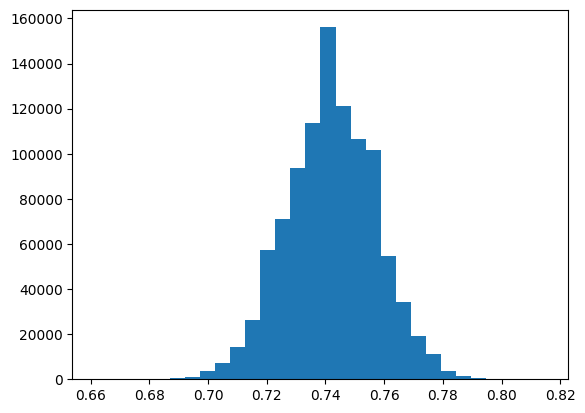

Mean:  0.7418818391356543
Confidence interval:  [0.71188475 0.77070828]


In [6]:
# Bootstrap for recall, precision and f1score
def get_precision(tp, fp):
    return tp / (tp + fp)

# 0 is for tp and 1 is for fp
tpfp = [0 for _ in range(tp)] + [1 for _ in range(fp)]

n_resamples = 1000000
part_size = 25
precisions = []
for i in range(n_resamples):
    part = np.random.choice(tpfp, size=len(tpfp), replace=True).tolist()
    tp = part.count(0)
    fp = part.count(1)
    precision = get_precision(tp, fp)
    precisions.append(precision)

plt.hist(precisions, bins = 30)
plt.show()
print("Mean: ", mean(precisions))
conf_interval_precision = np.percentile(precisions,[2.5,97.5])
print("Confidence interval: ",conf_interval_precision)